## Derivatives Pricing

The goal of this case study is to perform derivative pricing from a machine learning standpoint and use supervised regression-based model to learn the Black-Scholes option pricing model from simulated data.


## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Defining function and parameters](#1.2)
    * [2.3. Load Dataset](#1.3)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation and analysis](#3)
    * [4.1.Feature Selection](#3.1) 
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split and evaluation metrics](#4.1)
    * [5.2. Compare Models and Algorithms](#4.2)
* [6. Model Tuning and finalizing the model](#5)
* [7. Additional analysis: removing the volatilty data](#6)


<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, the derivative pricing
problem is defined in the regression framework, where the predicted variable is the
pricing of the option, and the predictor variables are the market data that are used as
inputs to the Black-Scholes option pricing model

Options have been used in finance as means to hedge risk in a nonlinear manner. They are are also used by speculators in order to take leveraged bets in the financial markets. Historically, people have used the Black Scholes formula.

$$  Se^{-q \tau}\Phi(d_1) - e^{-r \tau} K\Phi(d_2) \, $$

With

$$  d_1 = \frac{\ln(S/K) + (r - q + \sigma^2/2)\tau}{\sigma\sqrt{\tau}}  $$

and

$$  d_2 = \frac{\ln(S/K) + (r - q - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} = d_1 - \sigma\sqrt{\tau}  $$

Where we have;
    Stock price $S$;
    Strike price $K$;
    Risk-free rate $r$;
    Annual dividend yield $q$;
    Time to maturity $\tau = T-t$ (represented as a unit-less fraction of one year);
    Volatility $\sigma$

In order to make the logic simpler, we define *Moneyness* as $M = K/S$ and look at the prices in terms of per unit of current stock price. We also set $q$ as $0$ 

This simplifes the formula down to the following

$$  e^{-q \tau}\Phi\left( \frac{- \ln(M) + (r+ \sigma^2/2 )\tau}{\sigma\sqrt{\tau}}\right) - e^{-r \tau} M\Phi\left( \frac{- \ln(M) + (r - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} \right) \, $$

### Vol Suface

In the options market, there isn't a single value of volatility which gives us the correct price. We often find the volatility such that the output matches the price

### Simulation

In this exercise, we assume the the sturcture of the vol surface. In practice, we would source the data from a data vendor.

We use the following function to generate the option volatility surface

$$ \sigma(M, \tau) = \sigma_0 + \alpha\tau + \beta (M - 1)^2$$

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

### Python Imports

In [1]:
# Distribution functions
from scipy.stats import norm


# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


Using TensorFlow backend.


In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Defining functions and parameters

### True Parameters

In [3]:
true_alpha = 0.1
true_beta = 0.1
true_sigma0 = 0.2

In [4]:
risk_free_rate = 0.05

### Vol and Option Pricing Functions

In [5]:
def option_vol_from_surface(moneyness, time_to_maturity):
    return true_sigma0 + true_alpha * time_to_maturity + true_beta * np.square(moneyness - 1)

def call_option_price(moneyness, time_to_maturity, option_vol):
    d1=(np.log(1/moneyness)+(risk_free_rate+np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    d2=(np.log(1/moneyness)+(risk_free_rate-np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    return N_d1 - moneyness * np.exp(-risk_free_rate*time_to_maturity) * N_d2

<a id='1.3'></a>
## 2.3. Data Generation

In [6]:
N = 10000

Ks = 1+0.25*np.random.randn(N)
Ts = np.random.random(N)
Sigmas = np.array([option_vol_from_surface(k,t) for k,t in zip(Ks,Ts)])
Ps = np.array([call_option_price(k,t,sig) for k,t,sig in zip(Ks,Ts,Sigmas)])

### Set the Endog and Exog Data

In [7]:
Y = Ps

X = np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1,1), Sigmas.reshape(-1,1)], axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Vol'])

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [8]:
dataset.head()

,Price,Moneyness,Time,Vol
0,0.123052,1.204557,0.730944,0.277279
1,0.041143,0.966152,0.019369,0.202051
2,0.110939,0.940434,0.199577,0.220313
3,0.096628,1.257327,0.688852,0.275507
4,0.306569,0.742881,0.626105,0.269222


In [9]:
pd.set_option('precision', 3)
dataset.describe()

,Price,Moneyness,Time,Vol
count,10000.000,10000.000,1.000e+04,10000.000
mean,0.178,1.000,5.024e-01,0.257
std,0.135,0.251,2.871e-01,0.030
min,0.000,0.087,3.979e-05,0.200
25%,0.074,0.830,2.567e-01,0.231
50%,0.159,1.000,5.066e-01,0.257
75%,0.254,1.171,7.487e-01,0.281
max,0.914,1.964,1.000e+00,0.362


<a id='2.2'></a>
## 3.2. Data Visualization

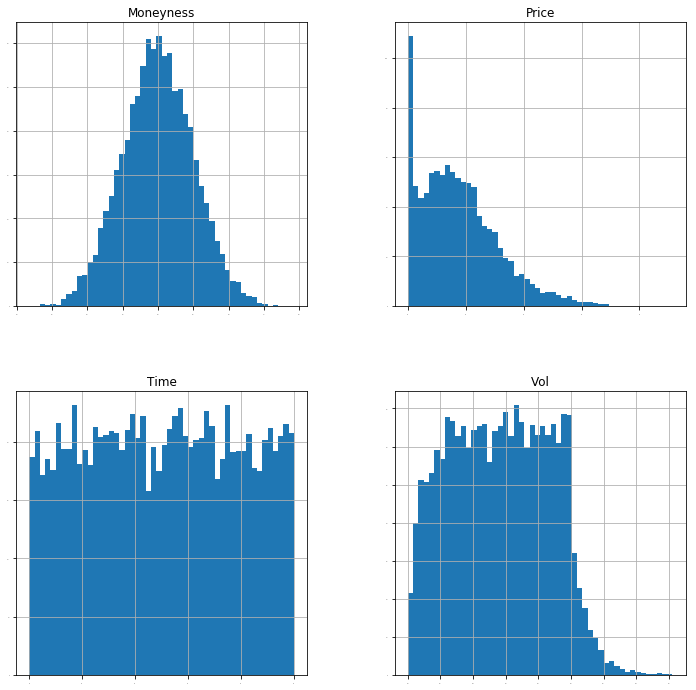

In [10]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

We can see that the price has an interesting distribution with a spike at $0$

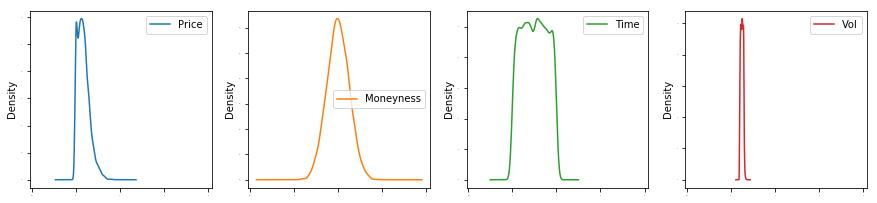

In [11]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

Next we look at the interaction between different variables

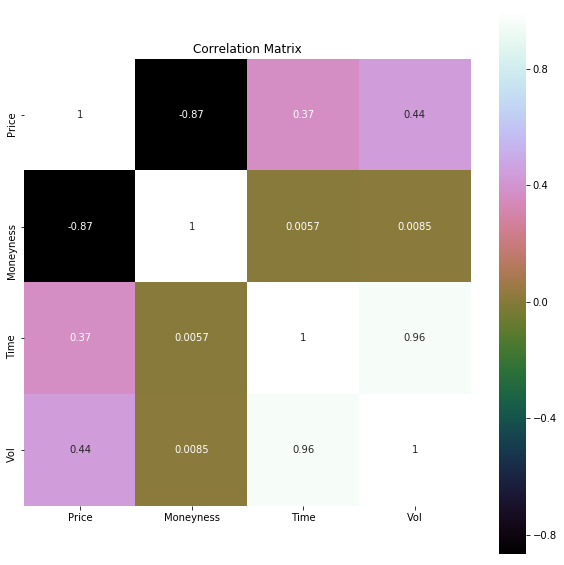

In [12]:
correlation = dataset.corr()
pyplot.figure(figsize=(10,10))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

In [ ]:
import matplotlib
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
#pyplot.xticks(fontsize=20)
pyplot.yticks(fontsize=20)
matplotlib.rc('xtick', labelsize=60) 
matplotlib.rc('ytick', labelsize=60)
pyplot.show()



We see some very interesting non linear analysis. This means that we expect our non linear models to do a better job than our linear models.

<a id='3'></a>
## 4. Data Preparation and Analysis

<a id='4.1'></a>
## 4.1. Univariate Feature Selection

We use SelectKBest function from sklearn

In [14]:
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Moneyness', 'Time', 'Vol'])
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
Moneyness,30218.836
Vol,2337.479
Time,1555.690


We observe that the moneyness is the most important variable for the price.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

In [15]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

We use the prebuilt scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. The parameters for the K fold analysis are defined as -

In [16]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

<a id='4.2'></a>
## 5.2. Compare Models and Algorithms

#### Linear Models and Regression Trees

In [105]:
models = []
#models.append(('LR', LinearRegression()))
#models.append(('LASSO', Lasso()))
#models.append(('EN', ElasticNet()))
#models.append(('KNN', KNeighborsRegressor()))
#models.append(('CART', DecisionTreeRegressor()))
#models.append(('SVR', SVR()))

#### Neural Network Predictor

In [106]:
models.append(('MLP', MLPRegressor()))

#### Boosting and Bagging Methods

In [107]:
# Boosting methods
#models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
#models.append(('ETR', ExtraTreesRegressor()))

In [108]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

MLP: 0.000042 (0.000023) 0.000021 0.000026
GBR: 0.000020 (0.000002) 0.000017 0.000023
RFR: 0.000002 (0.000000) 0.000000 0.000004


We being by looking at the Kfold analysis

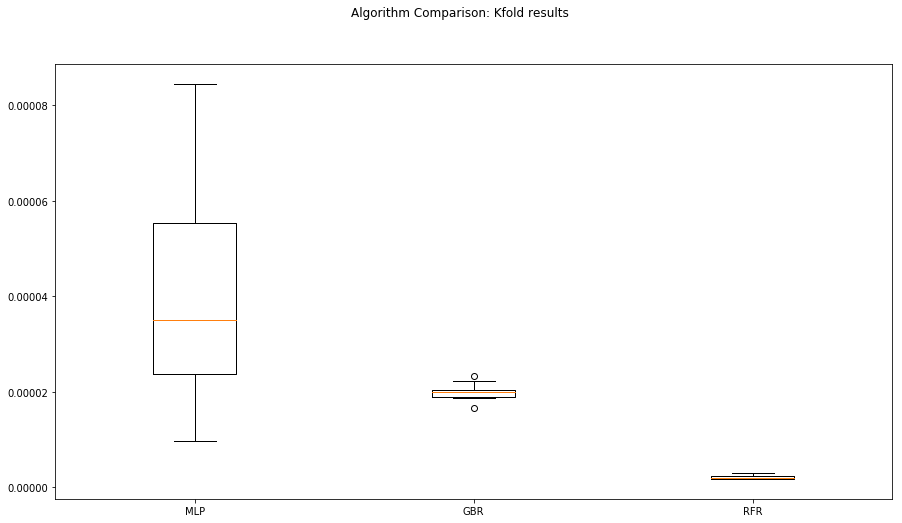

In [109]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

In order to get a better view, we remove the LASSO and Elastic Net

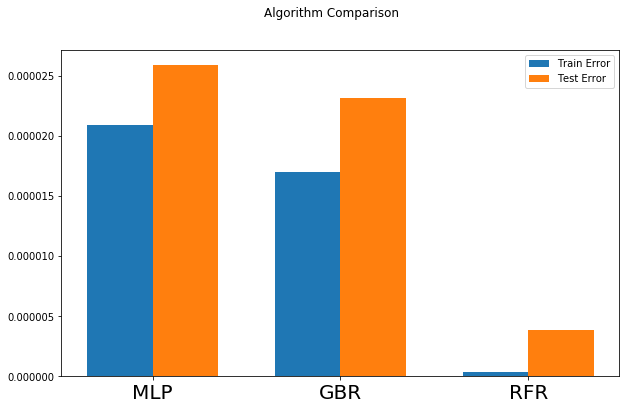

In [110]:
# compare algorithms
fig = pyplot.figure()
pyplot.xticks(fontsize=20)

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(10,6)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

We see that the multilayer perceptron (MLP) algorithm does a lot better that the linear algorithm. However, the CART and the Forest methods do a very good job as well. Given MLP is one of the best models we perform the grid search for MLP model in the next step.  

<a id='5'></a>
# 6. Model Tuning and finalising the model

As shown in the chart above the MLP model is one of the best model, so we perform the model tuning. We perform a grid search with different combination of hidden layers in the MLP model.  

In [41]:
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000022 using {'hidden_layer_sizes': (20, 30, 20)}
-0.000967 (0.000855) with: {'hidden_layer_sizes': (20,)}
-0.000116 (0.000085) with: {'hidden_layer_sizes': (50,)}
-0.000081 (0.000074) with: {'hidden_layer_sizes': (20, 20)}
-0.000022 (0.000012) with: {'hidden_layer_sizes': (20, 30, 20)}


The best model is the model with 3 layers with 20, 30 and 20 nodes in each layer respectively. 

In [42]:
# prepare model
model_tuned = MLPRegressor(hidden_layer_sizes=(20, 30, 20))
model_tuned.fit(X_train, Y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(20, 30, 20), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [43]:
# estimate accuracy on validation set
# transform the validation dataset
predictions = model_tuned.predict(X_test)
print(mean_squared_error(Y_test, predictions))

2.3161887171333322e-05


We see that the mean error (RMSE) is  3.08e-5 , which is less than a cent. Hence, the deep learning model does an excellent job of fitting the Black-Scholes option pricing model. The accuracy may be enhanced with more tuning.

<a id='6'></a>
# 7. Additonal analysis: removing the volatilty data

Next, we make the process harder by trying to predict the price without the volatility data.

In [44]:
X = X[:, :2]

In [45]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [46]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

In [47]:
models = []
models.append(('LR', LinearRegression()))
#models.append(('LASSO', Lasso()))
#models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [48]:
models.append(('MLP', MLPRegressor()))

In [49]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [50]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001980 (0.000131) 0.001978 0.002136
KNN: 0.000018 (0.000010) 0.000009 0.000024
CART: 0.000009 (0.000001) 0.000000 0.000010
SVR: 0.005802 (0.000136) 0.005807 0.005785
MLP: 0.000061 (0.000028) 0.000032 0.000037
ABR: 0.000595 (0.000028) 0.000597 0.000597
GBR: 0.000020 (0.000002) 0.000017 0.000023
RFR: 0.000002 (0.000000) 0.000000 0.000004
ETR: 0.000001 (0.000000) 0.000000 0.000003


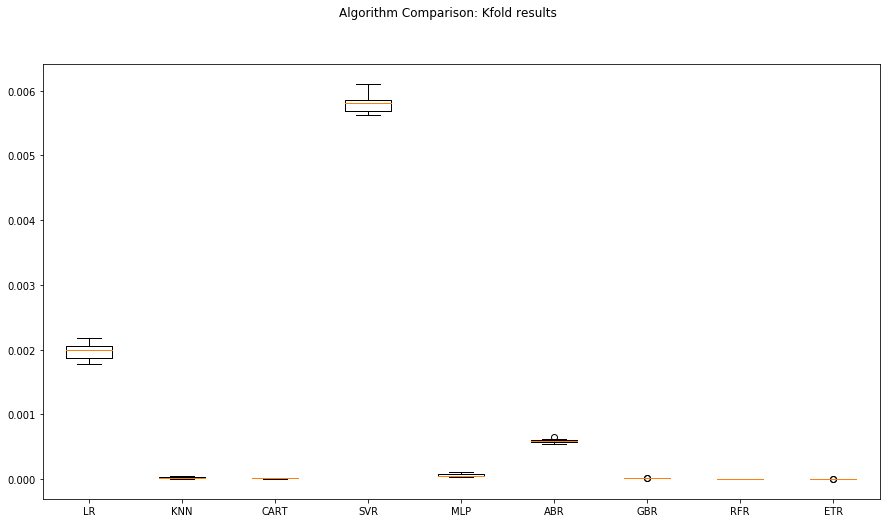

In [51]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

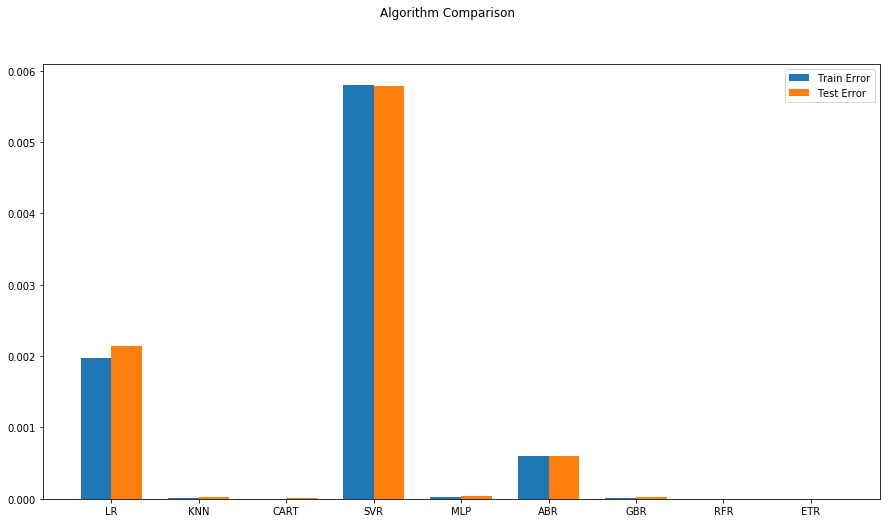

In [52]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

We can see that the linear regression now does a worse job than before, this is expected since we have added a greater amount of non linearity.

### Summary

* The linear regression model did not do as well as our non-linear models and the non-linear models
have a very good performance overall. 

* Artificial neural network (ANN) can reproduce the Black and Scholes
option pricing formula for a call option to a high degree of accuracy which means that we can leverage the efficient numerical calculation of machine learning in the derivative pricing without relying on the impractical assumptions made in the traditional
derivative pricing models. 